In [27]:
!pip install mosek 

# To execute the notebook directly in colab make sure your MOSEK license file is in one the locations
#
# /content/mosek.lic   or   /root/mosek/mosek.lic
#
# inside this project's internal filesystem.
#
# You will also need an API key from a stock data provider, or ready data files in a "stock_data" folder.
# See next cell for details.

import sys
print(sys.version)
import os
os.environ['MOSEKLM_LICENSE_FILE']="/content:/root/mosek"
import re
import glob
import datetime as dt

import numpy as np
np.set_printoptions(precision=5, linewidth=120, suppress=True)
import pandas as pd
pd.set_option('display.max_rows', None)
import statsmodels.api as sm
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
print('matplotlib: {}'.format(matplotlib.__version__))
from matplotlib.colors import LinearSegmentedColormap

from mosek.fusion import *

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200

from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

3.6.9 (default, Jan 26 2021, 15:33:00) 
[GCC 8.4.0]
matplotlib: 3.3.4


{'CodeCell': {'cm_config': {'autoCloseBrackets': False}}}

In [ ]:
# Data downloading:
# If the user has an API key for alphavantage.co, then this code part will download the data. 
# The code can be modified to download from other sources. To be able to run the examples, 
# and reproduce results in the cookbook, the files have to have the following format and content:
# - File name pattern: "daily_adjusted_[TICKER].csv", where TICKER is the symbol of a stock. 
# - The file contains at least columns "timestamp", "adjusted_close", and "volume".
# - The data is daily price/volume, covering at least the period from 2016-03-18 until 2021-03-18, 
# - Files are for the stocks PM, LMT, MCD, MMM, AAPL, MSFT, TXN, CSCO.
alphaToken = None
 
if alphaToken is not None:
    import requests
    import time
    
    list_tickers = ["PM", "LMT", "MCD", "MMM", "AAPL", "MSFT", "TXN", "CSCO"]
    
    for ticker in list_tickers:
        url = rf"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={ticker}&apikey={alphaToken}&outputsize=full&datatype=csv"
        result = requests.get(url, allow_redirects=True)
        fname = f"daily_adjusted_{ticker}.csv"
        folder = "stock_data"
        if not os.path.isdir(folder):
            os.mkdir(folder)
        open(os.path.join(folder, fname), "wb").write(result.content)
        print(f"Downloaded {fname}.")
        # Limit is 5 downloads per minute.
        time.sleep(12)   

In [28]:
class DataReader:
    def __init__(self, folder_path, exclude=None):
        self.folder_path = folder_path
        self.name_format = r"daily_adjusted_*.csv"
        self.exclude = exclude if exclude is not None else []
        self.df_prices = None
        self.df_volumes = None

    def read_data(self):
        # Get list of files from path, named as name_format 
        list_files = glob.glob(os.path.join(self.folder_path, self.name_format))
        file_names = "\n".join(list_files)
        print("Found data files: \n{}\n".format(file_names))

        # Exclude specified files
        for symbol in self.exclude:
            list_files.remove(os.path.join(self.folder_path, self.name_format.replace("*", symbol)))
    
        # Collect data from the files into a Dataframe
        dict_prices = {}
        dict_volumes = {}
        for file_name in list_files: 
            m = re.search(self.name_format.replace("*", "(.+)"), file_name)
            
            # Get symbol name
            symbol = m.group(1)
        
            # Read data file
            df_data = pd.read_csv(file_name)

            # Set timestamp as index 
            df_data['timestamp'] = pd.to_datetime(df_data['timestamp'])
            df_data = df_data.set_index('timestamp')
            df_data.index.name = "date"

            # Obtain adjusted close price data 
            dict_prices[symbol] = df_data['adjusted_close']
            dict_volumes[symbol] = df_data['volume']

        self.df_prices = pd.concat(dict_prices.values(), axis=1, keys=dict_prices.keys()).sort_index()
        self.df_volumes = pd.concat(dict_volumes.values(), axis=1, keys=dict_volumes.keys()).sort_index()
        
    def get_period(self, start_date, end_date):              
        start_idx = self.df_prices.index.get_loc(pd.to_datetime(start_date), method='nearest')
        end_idx = self.df_prices.index.get_loc(pd.to_datetime(end_date), method='nearest')
        df_prices = self.df_prices.iloc[start_idx:(end_idx + 1)]
        df_volumes = self.df_volumes.iloc[start_idx:(end_idx + 1)]
        
        return df_prices, df_volumes

In [29]:
# We load daily stock price data from CSV files. The data is adjusted for splits and dividends. 
# The files are in "stock_data" folder, named as "daily_adjusted_[TICKER].csv"
dr = DataReader(folder_path="stock_data", exclude=["SPY"])
dr.read_data()
df_prices, df_volumes = dr.get_period(start_date="2016-03-18", end_date="2021-03-18")
columns = ["PM", "LMT", "MCD", "MMM", "AAPL", "MSFT", "TXN", "CSCO"]
df_prices = df_prices[columns]
df_volumes = df_volumes[columns]

Found data files: 
stock_data/daily_adjusted_AAPL.csv
stock_data/daily_adjusted_PM.csv
stock_data/daily_adjusted_CSCO.csv
stock_data/daily_adjusted_TXN.csv
stock_data/daily_adjusted_MMM.csv
stock_data/daily_adjusted_MCD.csv
stock_data/daily_adjusted_SPY.csv
stock_data/daily_adjusted_MSFT.csv
stock_data/daily_adjusted_LMT.csv



In [30]:
# Compute average daily volume and daily volatility (std. dev.)
df_lin_returns = df_prices.pct_change()
volatility = df_lin_returns.std()
volume = (df_volumes * df_prices).mean()

In [31]:
# Convert daily prices to weekly prices
df_weekly_prices = df_prices.resample('W').last()

In [32]:
# Compute weekly logarithmic returns
df_weekly_log_returns = np.log(df_weekly_prices) - np.log(df_weekly_prices.shift(1))
df_weekly_log_returns = df_weekly_log_returns.dropna(how='all')
df_weekly_log_returns = df_weekly_log_returns.fillna(0)

array([[<AxesSubplot:title={'center':'PM'}>, <AxesSubplot:title={'center':'LMT'}>,
        <AxesSubplot:title={'center':'MCD'}>],
       [<AxesSubplot:title={'center':'MMM'}>, <AxesSubplot:title={'center':'AAPL'}>,
        <AxesSubplot:title={'center':'MSFT'}>],
       [<AxesSubplot:title={'center':'TXN'}>, <AxesSubplot:title={'center':'CSCO'}>, <AxesSubplot:>]], dtype=object)

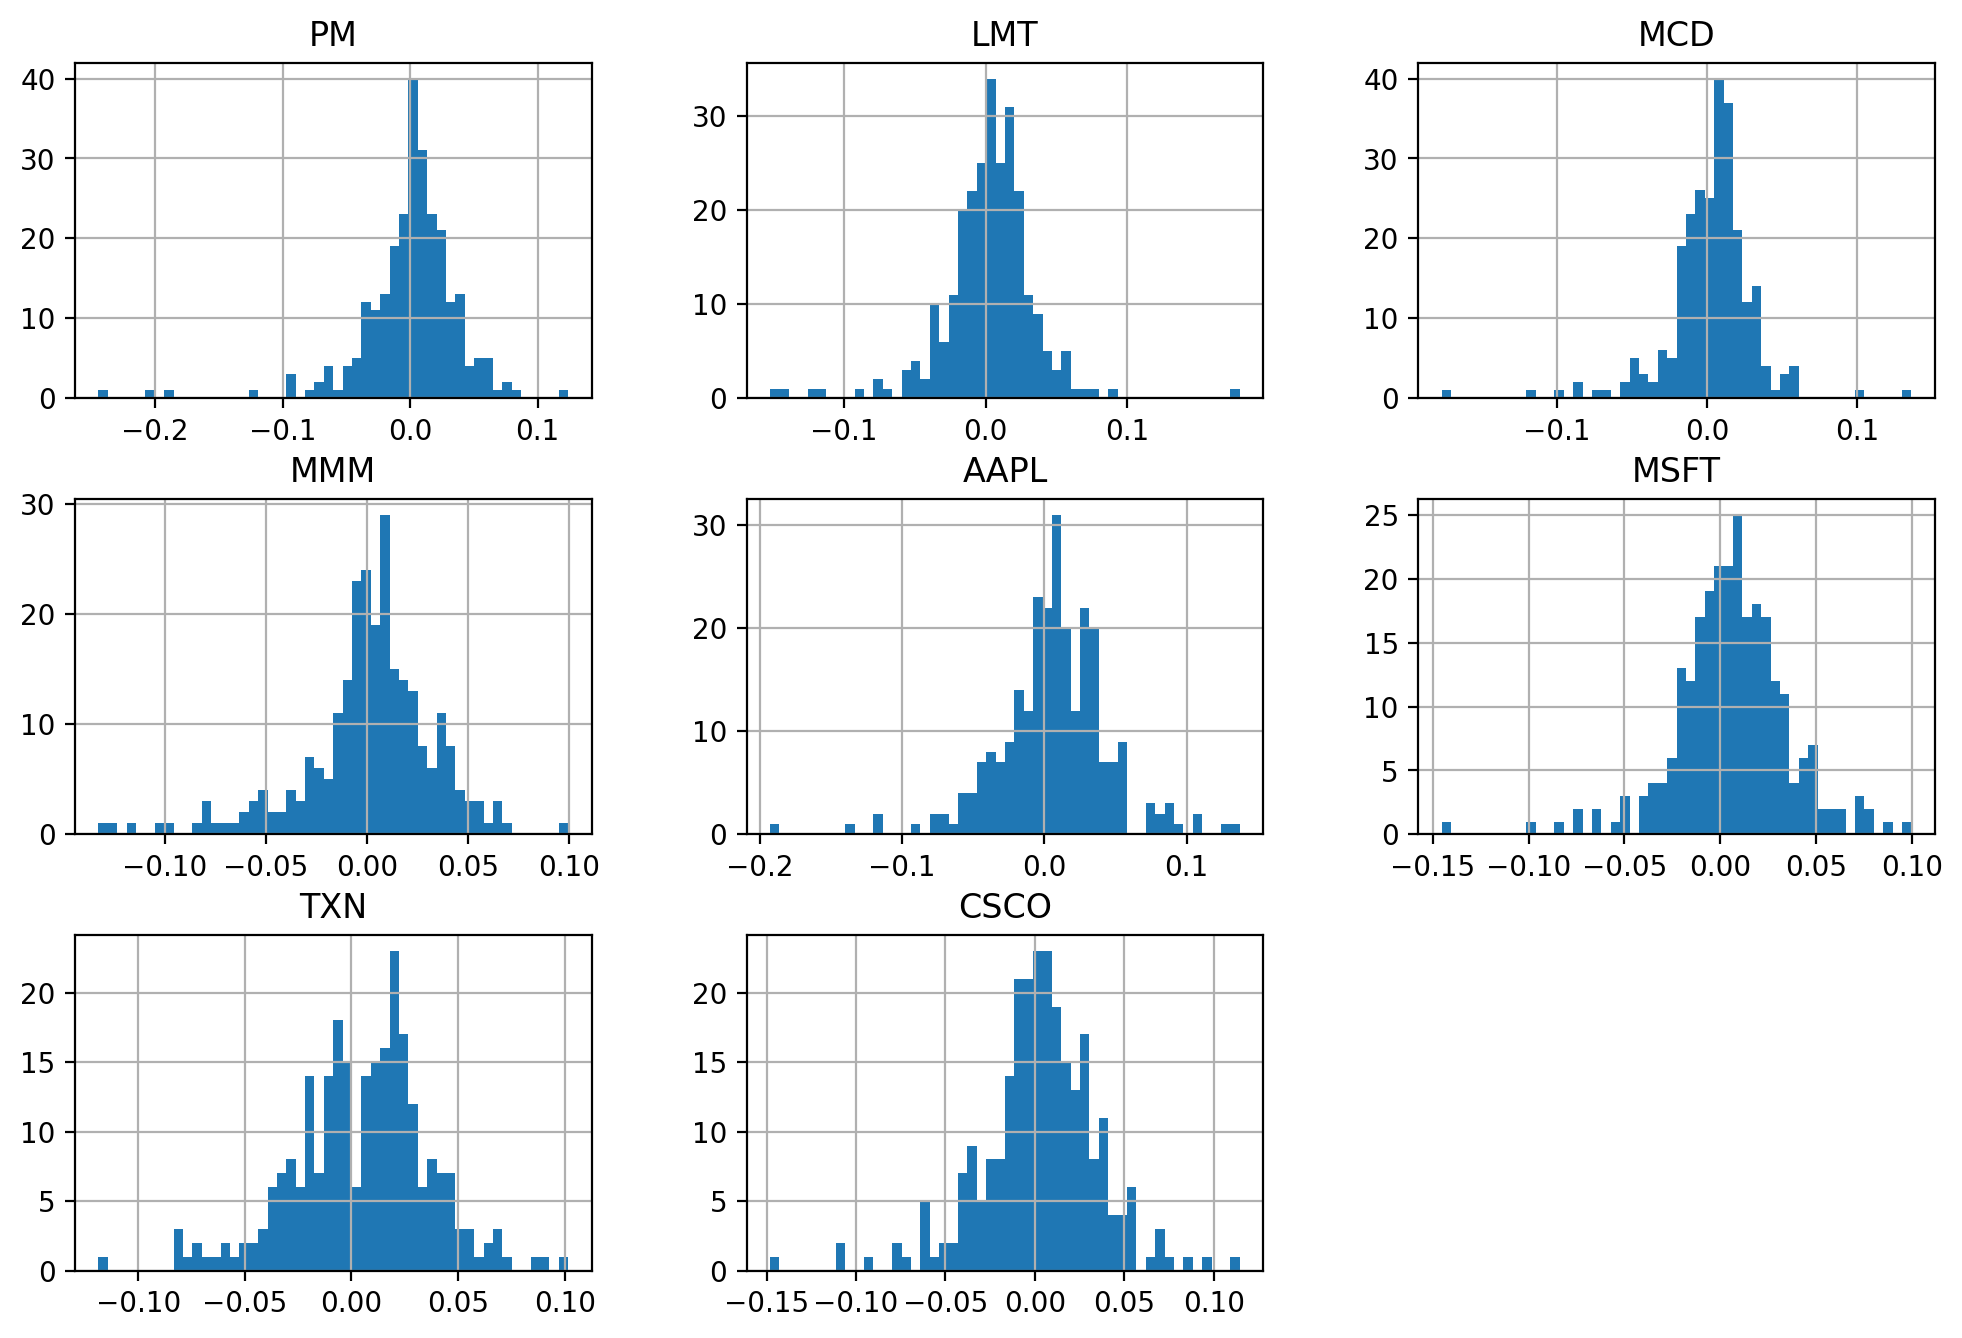

In [33]:
# Show histograms of weekly logarithmic returns
df_weekly_log_returns.hist(bins=50)

In [34]:
# Compute mean and covariance of weekly logarithmic returns
return_array = df_weekly_log_returns.to_numpy()
T = return_array.shape[0]
m_weekly_log = np.mean(return_array, axis=0)
S_weekly_log = np.cov(return_array.transpose())

In [35]:
# Convert weekly logarithmic return statistics to yearly linear return statistics
def get_lin_parameters(m_weekly_log, S_weekly_log):              
    # Project logarithmic return statistics to investment horizon
    m_log = 52 * m_weekly_log
    S_log = 52 * S_weekly_log
    
    # Pricing
    p_0 = df_weekly_prices.iloc[0].to_numpy()
    m_P = p_0 * np.exp(m_log + 1/2*np.diag(S_log))
    S_P = np.outer(m_P, m_P) * (np.exp(S_log) - 1)
    
    # Linear return statistics on the investment horizon
    m = 1 / p_0 * m_P - 1
    S = 1 / np.outer(p_0, p_0) * S_P

    return m, S

In [36]:
def EfficientFrontier(N, m, G, deltas, a, beta, rf):

    with Model("Case study") as M:
        # Settings
        #M.setLogHandler(sys.stdout)
        
        # Variables 
        # The variable x is the fraction of holdings in each security. 
        # It is restricted to be positive, which imposes the constraint of no short-selling.   
        x = M.variable("x", N, Domain.greaterThan(0.0))
        
        # Variable for risk-free asset (cash account)
        xf = M.variable("xf", 1, Domain.greaterThan(0.0))        
        
        # The variable s models the portfolio variance term in the objective.
        s = M.variable("s", 1, Domain.unbounded())
        
        # Auxiliary variable to model market impact 
        t = M.variable("t", N, Domain.unbounded())

        # Budget constraint with transaction cost terms
        M.constraint('budget', Expr.sum(Expr.hstack(Expr.sum(x), xf, Expr.dot(a, t))), Domain.equalsTo(1))
        
        # Power cone to model market impact 
        M.constraint('market_impact', Expr.hstack(t, Expr.constTerm(N, 1.0), x), Domain.inPPowerCone(1.0 / beta))
        
        # Objective (quadratic utility version)
        delta = M.parameter()
        M.objective('obj', ObjectiveSense.Maximize, 
                    Expr.sub(
                        Expr.add(Expr.dot(m, x), Expr.mul(rf, xf)), 
                        Expr.mul(delta, s)
                    )
        )
        
        # Conic constraint for the portfolio variance
        M.constraint('risk', Expr.vstack(s, 1, Expr.mul(G.transpose(), x)), Domain.inRotatedQCone())
    
        columns = ["delta", "obj", "return", "risk", "t_resid", "x_sum", "xf", "tcost"] + df_prices.columns.tolist()
        
        df_result = pd.DataFrame(columns=columns)
        for d in deltas:
            # Update parameter
            delta.setValue(d);
            
            # Solve optimization
            M.solve()
            
            # Save results
            portfolio_return = m @ x.level() + np.array([rf]) @ xf.level()
            portfolio_risk = np.sqrt(2 * s.level()[0]) 
            risky_return = m @ x.level()
            t_resid = t.level() - np.abs(x.level())**beta
            row = pd.Series([d, M.primalObjValue(), portfolio_return, portfolio_risk, 
                             sum(t_resid), sum(x.level()), sum(xf.level()), t.level() @ a] + list(x.level()), index=columns)
     
            df_result = df_result.append(row, ignore_index=True)

        return df_result

In [37]:
# Number of securities
N = df_prices.shape[1]  

# Get optimization parameters
m, S = get_lin_parameters(m_weekly_log, S_weekly_log)

# Cholesky factor of S to use in conic risk constraint
G = np.linalg.cholesky(S)

In [38]:
# Market impact coefficient
beta = 3 / 2
c = 1
rf = 0.01
portfolio_value = 10**10

# a1 means no impact, a2 means impact
a1 = np.zeros(N)
a2 = (c * volatility * (volume / portfolio_value)**(1 - beta) / beta).to_numpy()

,delta,obj,return,risk,t_resid,x_sum,xf,tcost,PM,LMT,MCD,MMM,AAPL,MSFT,TXN,CSCO
0,100.000000,0.018791,0.027581,0.013259,1.580483e-06,0.047434,9.523858e-01,0.000180,5.251679e-10,2.383337e-09,1.384234e-08,6.584920e-10,0.005843,0.030483,1.110813e-02,1.421053e-09
1,73.861998,0.021902,0.033802,0.017951,9.985189e-07,0.064218,9.354987e-01,0.000283,3.335287e-10,1.441087e-09,9.180326e-09,4.187055e-10,0.007912,0.041270,1.503672e-02,8.004621e-10
2,54.555948,0.026113,0.042223,0.024302,1.972479e-06,0.086941,9.126134e-01,0.000446,5.957892e-10,3.393753e-09,1.824527e-08,7.700856e-10,0.010714,0.055872,2.035460e-02,1.863665e-09
3,40.296113,0.031814,0.053624,0.032901,1.913194e-06,0.117702,8.815958e-01,0.000702,5.692219e-10,3.090415e-09,1.587572e-08,7.167047e-10,0.014507,0.075643,2.755203e-02,1.728271e-09
4,29.763514,0.039532,0.069058,0.044543,9.310427e-07,0.159346,8.395482e-01,0.001106,2.687742e-10,1.367559e-09,5.773796e-09,3.443308e-10,0.019645,0.102408,3.729327e-02,8.142930e-10
5,21.983926,0.049980,0.089951,0.060302,1.169694e-06,0.215721,7.825363e-01,0.001742,3.191234e-10,1.795603e-09,9.599321e-09,4.107614e-10,0.026603,0.138643,5.047615e-02,9.722843e-10
6,16.237767,0.064124,0.118234,0.081638,2.088297e-06,0.292041,7.052150e-01,0.002744,4.108198e-10,1.599909e-09,1.221492e-08,5.193537e-10,0.036023,0.187699,6.831873e-02,8.010153e-10
7,11.993539,0.083271,0.156520,0.110520,1.259728e-06,0.395354,6.003236e-01,0.004322,3.963721e-10,2.285948e-09,1.289668e-08,5.066008e-10,0.048788,0.254110,9.245709e-02,1.165601e-09
8,8.858668,0.109190,0.208345,0.149620,4.144328e-06,0.535211,4.579818e-01,0.006807,1.000057e-09,5.778798e-09,2.694376e-08,1.284657e-09,0.066074,0.344016,1.251214e-01,3.265593e-09
9,6.543189,0.144275,0.278497,0.202550,6.734876e-07,0.724531,2.647491e-01,0.010720,1.315150e-10,6.191260e-10,4.080577e-09,1.765359e-10,0.089490,0.465728,1.693124e-01,4.025405e-10


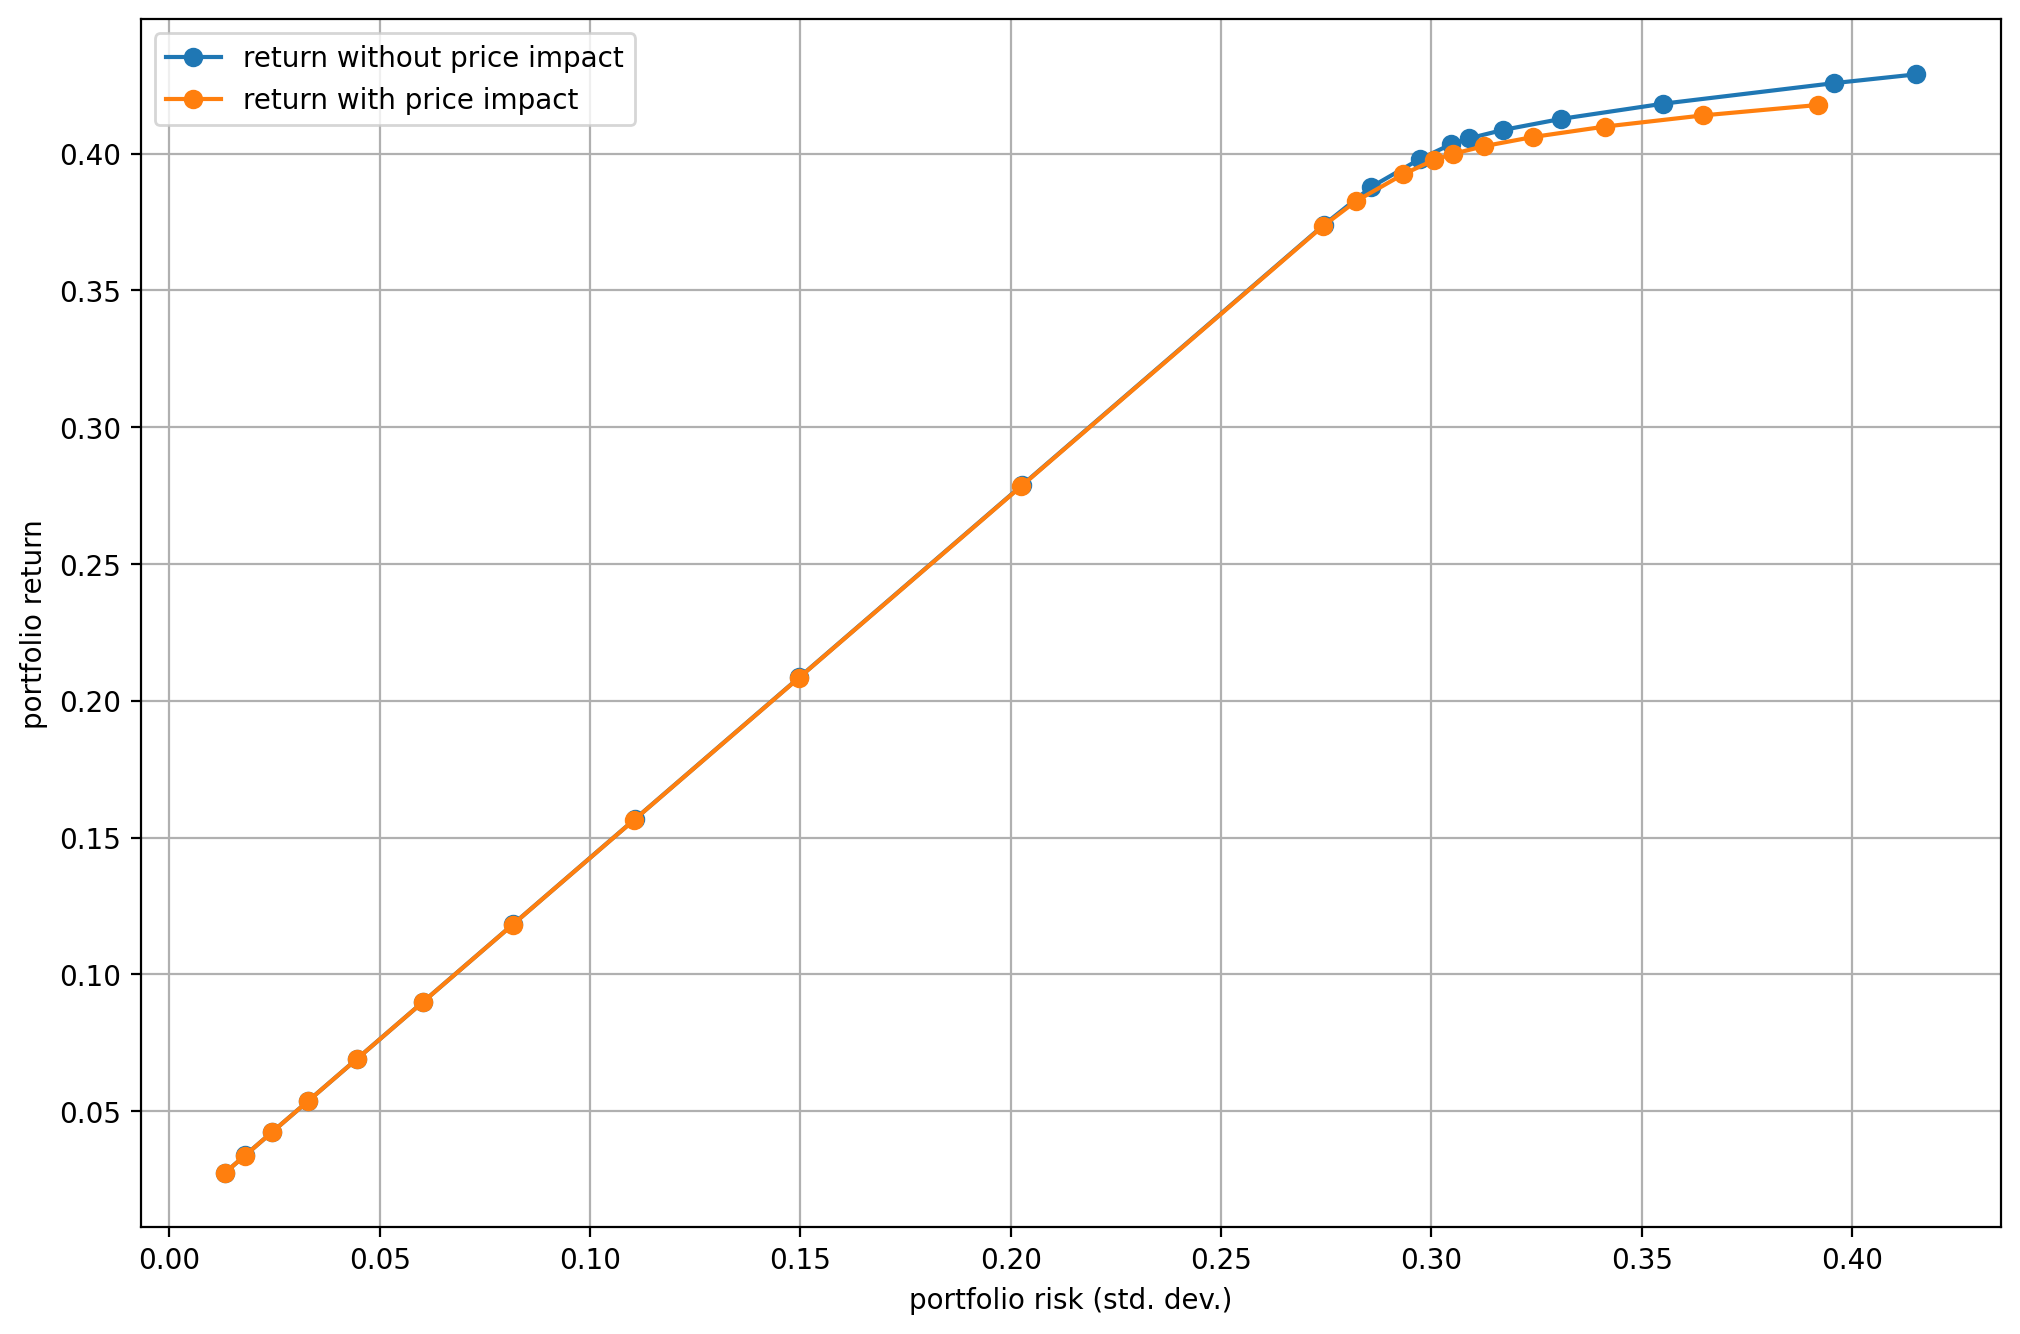

In [39]:
deltas = np.logspace(start=-0.5, stop=2, num=20)[::-1]

ax = plt.gca()
for a in [a1, a2]:
    df_result = EfficientFrontier(N, m, G, deltas, a, beta, rf)
    df_result.plot(ax=ax, x="risk", y="return", style="-o", 
                   xlabel="portfolio risk (std. dev.)", ylabel="portfolio return", grid=True)
ax.legend(["return without price impact", "return with price impact"]);
df_result